# <u>Regression Module Project: Estimating Zillow Home Value</u>

### Project Scenario:
You are a junior data scientist on the __Zillow data science team__ and recieve the following email in your inbox:

__We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.__

We have a model already, but we are hoping your insights can help us improve it. __I need recommendations on a way to make a better model.__ Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

(One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in).

-- The Zillow Data Science Team



## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from acquire import get_zillow
from prepare import prepare_zillow

from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering, scaled_data, assessed_value_regression_plot


## Acquire prepped and split data

#### - Moving forward, train data will be used to prevent data leakage

In [2]:
train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


In [3]:
# Examine split integrity
print(f'\n\tTrain Shape: {train.shape}\n\n\tValidate Shape: {validate.shape}\n\n\tTest Shape: {test.shape}' )


	Train Shape: (29297, 8)

	Validate Shape: (12557, 8)

	Test Shape: (10464, 8)


## <u>Initial Data Explolatory Analysis</u>

In [4]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_date,trans_month
16035,3.0,2.0,1522.0,64360.0,1925.0,6037.0,2017-04-14,4
44800,2.0,1.0,900.0,338073.0,1951.0,6037.0,2017-08-10,8
20047,2.0,1.0,807.0,51727.0,1951.0,6037.0,2017-04-21,4
5077,3.0,3.0,2458.0,653996.0,1985.0,6059.0,2017-02-16,2
36597,3.0,2.0,1386.0,242779.0,1962.0,6037.0,2017-06-30,6


In [5]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])



In [6]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037


## Map locations with National Data

In [7]:
# Map fits with national data  
# (Source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

# Get unique locations
location = train.zip_code.unique()
location

array([6037, 6059, 6111])

### Create new columns with names of city

In [8]:
train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})

train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


In [9]:
# from uszipcode import SearchEngine, SimpleZipcode, Zipcode

# search = SearchEngine()

# def zco(x):
#     city = search.by_zipcode(x).major_city
#     return city if city else 'None'

# train['metro'] = train['zipcode'].apply(zco)

In [10]:
# Describe the data

train.describe()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
count,29297.000000,29297.000000,29297.000000,2.929700e+04,29297.000000,29297.000000,29297.000000,29297.000000
mean,3.311773,2.303137,1922.911561,5.258636e+05,5.051712,16.478479,1963.286821,6049.144861
std,0.933666,1.012818,987.408513,7.157899e+05,2.347439,8.964306,23.128629,21.030609
min,0.000000,0.000000,152.000000,9.242000e+03,1.000000,1.000000,1878.000000,6037.000000
25%,3.000000,2.000000,1270.000000,1.933730e+05,3.000000,9.000000,1950.000000,6037.000000
50%,3.000000,2.000000,1664.000000,3.724420e+05,5.000000,16.000000,1961.000000,6037.000000
75%,4.000000,3.000000,2312.000000,6.190000e+05,7.000000,24.000000,1979.000000,6059.000000
max,12.000000,11.000000,21929.000000,2.434570e+07,9.000000,31.000000,2016.000000,6111.000000


In [11]:
# Get data summary information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29297 entries, 16035 to 39200
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed_count       29297 non-null  float64
 1   bath_count      29297 non-null  float64
 2   square_feet     29297 non-null  float64
 3   assessed_value  29297 non-null  float64
 4   trans_month     29297 non-null  int64  
 5   trans_day       29297 non-null  int64  
 6   built_year      29297 non-null  int64  
 7   zip_code        29297 non-null  int64  
 8   city            29297 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 2.2+ MB


In [12]:
# Check for null values
train.isnull().sum()

bed_count         0
bath_count        0
square_feet       0
assessed_value    0
trans_month       0
trans_day         0
built_year        0
zip_code          0
city              0
dtype: int64

In [13]:
# Any null columns?
train.columns.isnull().any()

False

In [14]:
# Value counts
train.value_counts()

bed_count  bath_count  square_feet  assessed_value  trans_month  trans_day  built_year  zip_code  city       
3.0        2.0         1050.0       259334.0        5            25         1960        6037      Los Angeles    2
0.0        0.0         400.0        49627.0         5            1          1950        6037      Los Angeles    1
4.0        2.0         1576.0       82375.0         5            1          1952        6037      Los Angeles    1
                       1578.0       397610.0        5            2          1978        6111      Ventura        1
                                    96458.0         6            16         1959        6037      Los Angeles    1
                                                                                                                ..
3.0        2.0         1337.0       109332.0        6            1          1953        6037      Los Angeles    1
                       1336.0       965007.0        1            26         1946     

## Data Scalling

### Standard Ccaler Choosen: (Result will have a mean of 0 and a standard deviation of 1)


In [15]:

# train_to_scale = train.copy()
# validate_to_scale = validate.copy()
# test_to_scale = test.copy()

# train_to_scale = train_to_scale.drop(columns = 'city')
# validate_to_scale = validate_to_scale.drop(columns = 'city')
# test_to_scale = test_to_scale.drop(columns = 'city')


# # Create Scaled dataframes
# train_scaled, validate_scaled, test_scaled = scaled_data(train_to_scale, validate_to_scale, test_to_scale)
# # Reshape array & rename cols 
# bed_features_scaled = pd.DataFrame(np.array(train_scaled[['bed_count', 'assessed_value']].to_numpy()), columns = ['bed_count', 'assessed_value'])
# bed_features_scaled.head(3)


# # Map X, and y to features of interest and check lenght

# X = bed_features_scaled['bed_count']
# y = bed_features_scaled['assessed_value']

# plt.figure(figsize = (16, 10))
# plt.scatter(X, y)
# plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
# plt.xlabel('Bed Count', size = 15, color = 'black')
# plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
# plt.show()
# --------------------------------------
# # # Create a scaler object
# # scaler = sklearn.preprocessing.StandardScaler()

# # # Fit on train subset
# # scaler.fit(train)

#  # Transform scaler to train, validate and test subsets
# train_scaled = scaler.transform(train)
# validate_scaled = scaler.transform(validate)
# test_scaled = scaler.transform(test)

# plt.figure(figsize=(13, 6))
# plt.subplot(121)
# plt.hist(train, bins=25, ec='black')
# plt.title('Original')
# plt.subplot(122)
# plt.hist(train_scaled, bins=25, ec='black')
# plt.title('Scaled')

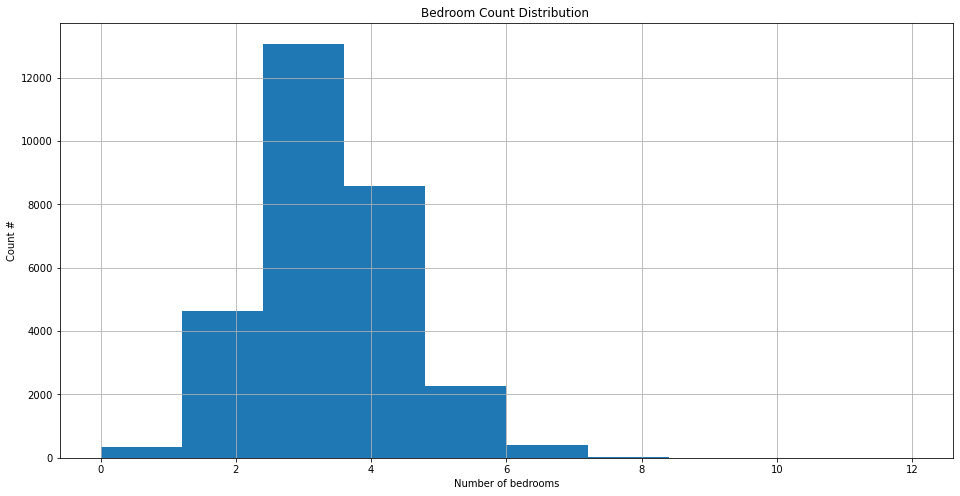

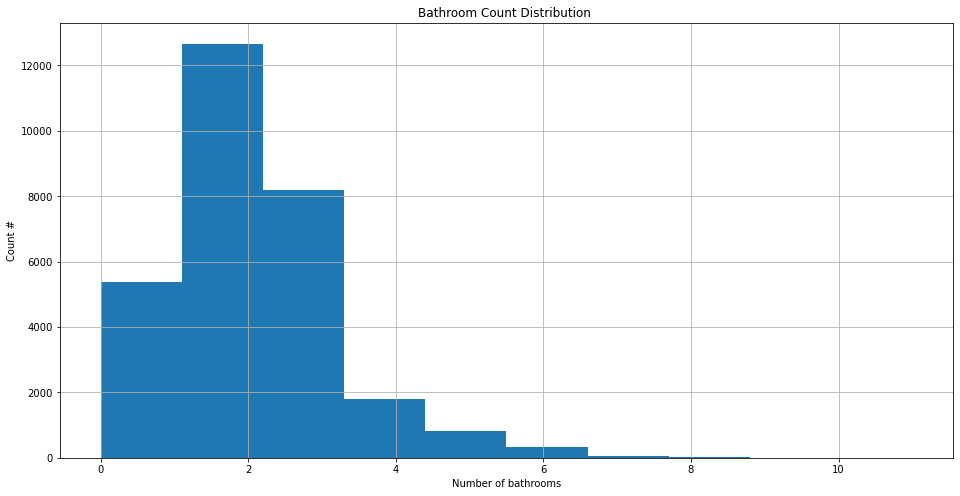

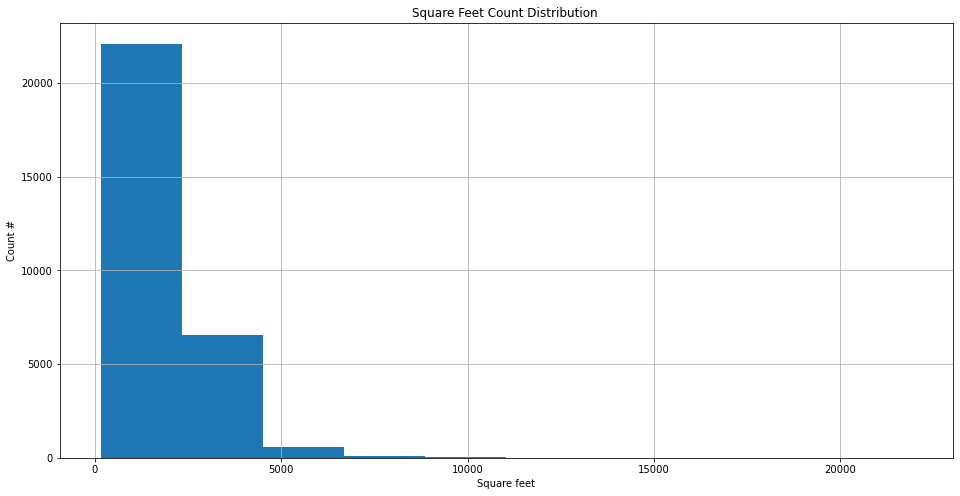

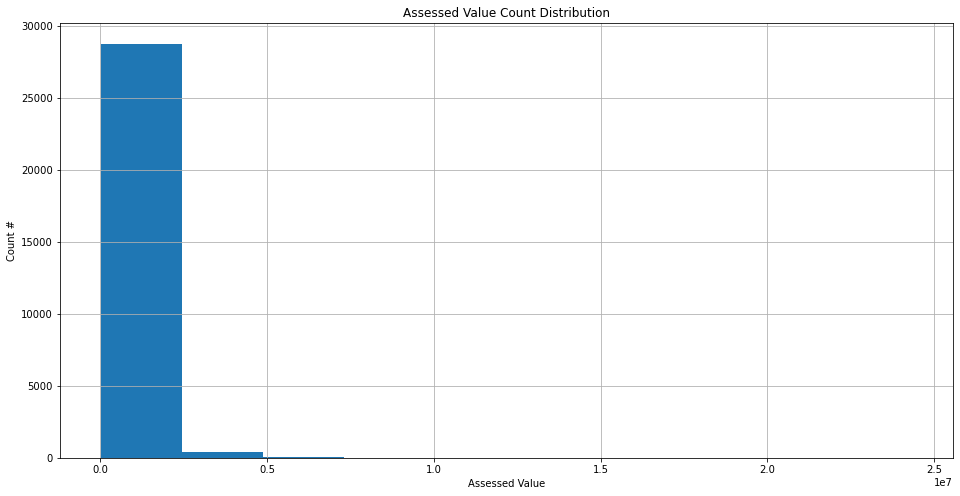

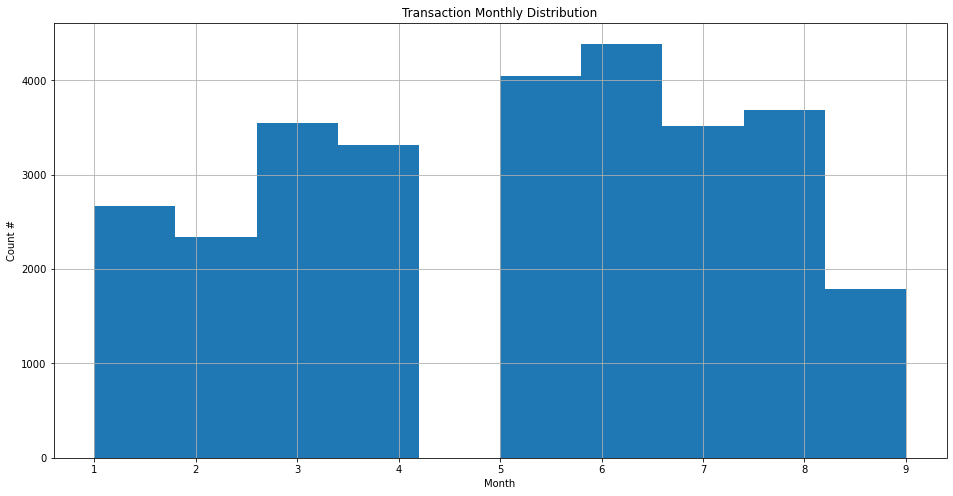

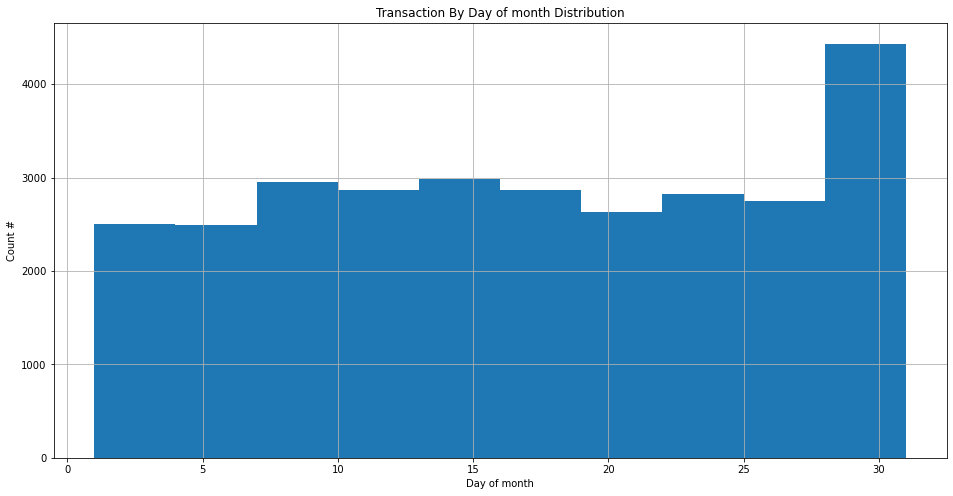

In [16]:
# Initial Visualizations
plt.figure(figsize = (16, 8))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Square Feet Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Assessed Value Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Assessed Value')
train.assessed_value.hist()
plt.show()

plt.figure(figsize = (16, 8))
plt.title('Transaction Monthly Distribution')
plt.ylabel('Count #')
plt.xlabel('Month')
train.trans_month.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Transaction By Day of month Distribution')
plt.ylabel('Count #')
plt.xlabel('Day of month')
train.trans_day.hist()
plt.show()

In [17]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


## <u>Key Findings:</u>
### __NOTE:_ All homes in dataset are zillow homes of 2017
- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s.
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s.
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Most transactions were average throughout the year but peaked towards the last few days of teh year. 


## Initial possible drivers for home value:

- Homes with __square feet greater than 2000__ are more likely to be bougth and sold than those below that value
- Homes with bedroom count between __3 and 4__ are more likely to generate more assessed value than other homes.
- The more the __batrooms (over 3) a home has__, the likely the rise in assessed value. 
- Homes __built after the year 2000__ are more likely to have higher assessed home value than those built before that year.
- Homes in __Los Angels__ are likely to be highly assessed due to size of city than those in Orange and Ventura


# <u>Exploration Phase:</u>

## What Arives Assessed Value?

## QUIZ 1: Is there a correlation between homes square feet and its assessed value?


##### H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
##### H1 = 'Homes square feet is correlated to its variation in assessed value.'

> ### Visualize Square Feet VS Assessed Value

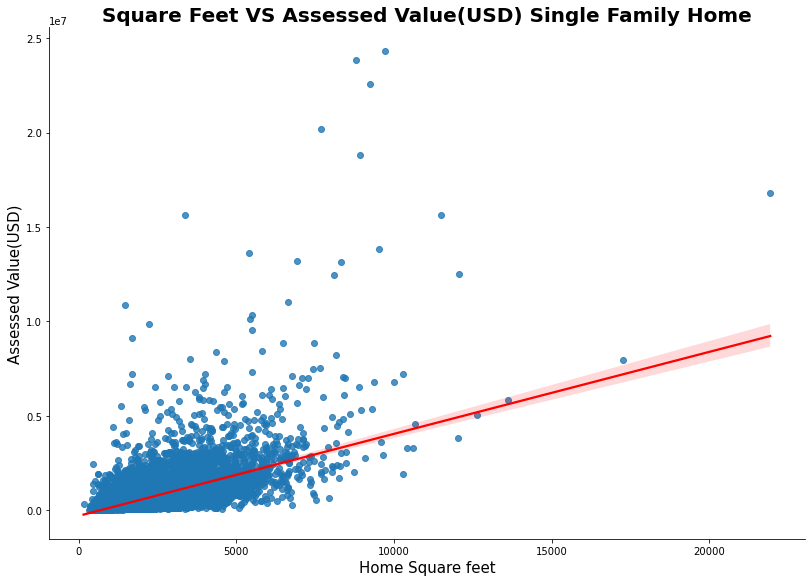

In [18]:

# Create lmplot showing regression
sns.lmplot(x = "square_feet", y = "assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws = {'color': 'red'})

plt.title('Square Feet VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Square feet', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')



plt.show()




##### Calculate the 'r' and 'p' values

In [19]:
# Hypothesis
H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
H1 = 'Homes square feet is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.square_feet, train.assessed_value)

print('\nSPEARMANSR SQUARE FEET')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR SQUARE FEET

	- Correlation Coefficient: 0.5299891724996166

	- P-value: 0.0



##### Test the hypothesis

In [20]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")



REJECT: There is no correlation between the homes square feet and and its variation in assessed value.



## QUIZ 2: Is there a correlation between home's number of bedrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bedroom and and its variation in assessed value.'
##### H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

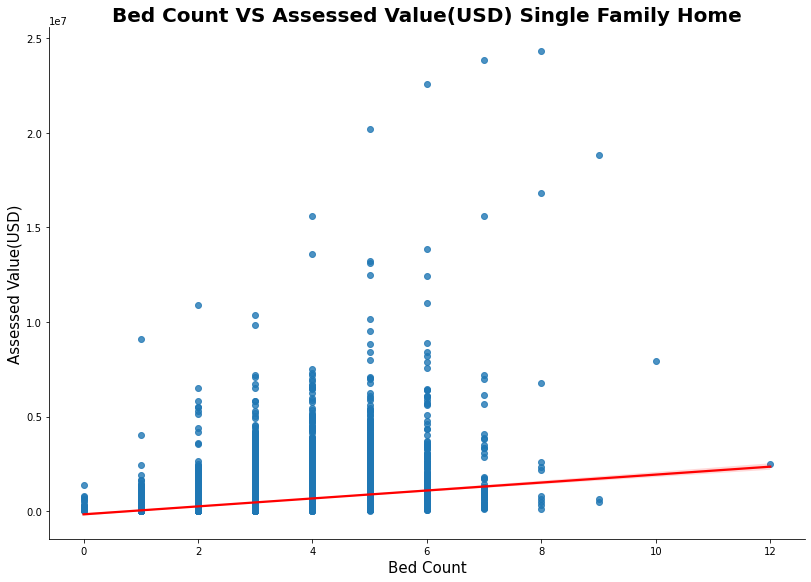

In [21]:
# Create lmplot showing regression
sns.lmplot(x="bed_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bed Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [22]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bedrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.bed_count, train.assessed_value)

print('\nSPEARMANSR BED COUNT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR BED COUNT

	- Correlation Coefficient: 0.2965257871082601

	- P-value: 0.0



##### Test the hypothesis

In [23]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between the home's number of bedrooms and and its variation in assessed value.



## QUIZ 3: Is there a correlation between home's number of bathrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
##### H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

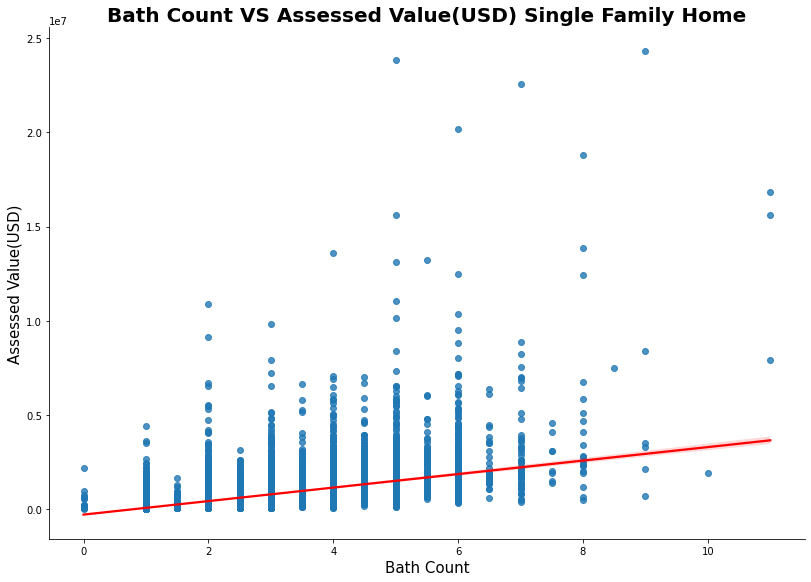

In [24]:
# Create lmplot showing regression
sns.lmplot(x="bath_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bath Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bath Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [25]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.bath_count, train.assessed_value)

print('\nSPEARMANSR BATH COUNT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR BATH COUNT

	- Correlation Coefficient: 0.48934984695378525

	- P-value: 0.0



##### Test the hypothesis

In [26]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between the home's number of bathrooms and and its variation in assessed value.



## QUIZ 4: Is there a correlation between transaction month and its assessed value?

##### H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
##### H1 = 'Transaction month is correlated to its variation in assessed value.'

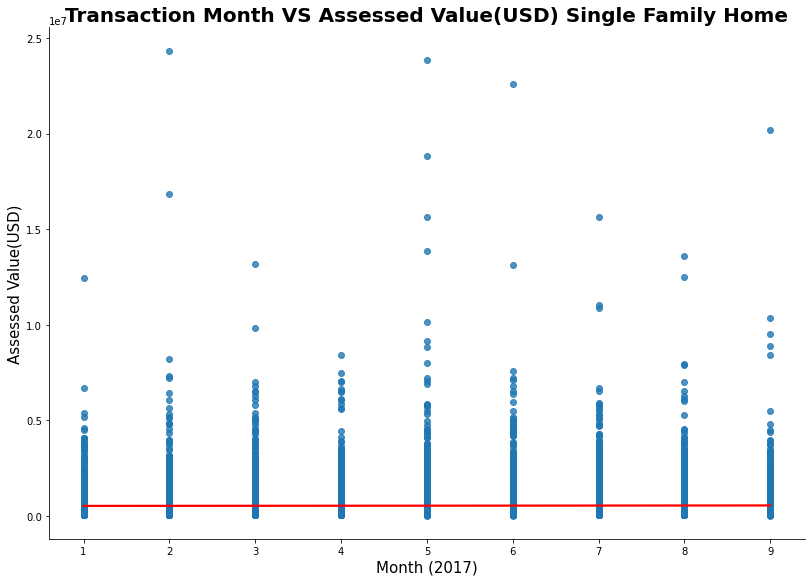

In [27]:
# Create lmplot showing regression
sns.lmplot(x="trans_month", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Transaction Month VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Month (2017)', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()




##### Calculate the 'r' and 'p' values

In [28]:
# Formulated hypothesis
H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
H1 = 'Transaction month is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train.trans_month, train.assessed_value)

print('\nSPEARMANSR TRANSACTION MONTH')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR TRANSACTION MONTH

	- Correlation Coefficient: 0.01800608852478578

	- P-value: 0.002055413288957108



##### Test the hypothesis

In [29]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between transaction month and and its variation in assessed value.



## QUIZ 5: Is there a correlation between a home\'s location and its assessed value?

##### H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
##### H1 = 'A home\s location is correlated to its variation in assessed value.'


### 6037 ==  'Los Angeles'
### 6059 == 'Orange'
### 6111 == 'Ventura'


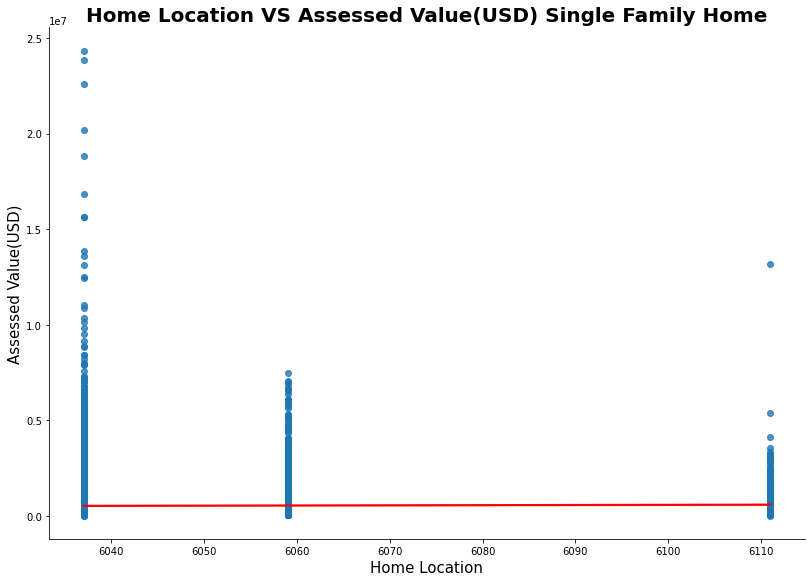

In [30]:
# Create lmplot showing regression
sns.lmplot(x="zip_code", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Home Location VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Location', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
# plt.text(1, 50, f'6037 == Los Angeles')
# plt.text(1, 40, f'6059 == Orange')
# plt.text(1, 30, f'6111 == Ventura')
plt.show()


# 6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'

##### Calculate the 'r' and 'p' values

In [31]:
# Formulated hypothesis
H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
H1 = 'A home\'s location is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.zip_code, train.assessed_value)

print('\nSPEARMANSR LOCATION')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR LOCATION

	- Correlation Coefficient: 0.17582466391364532

	- P-value: 4.602786368446637e-202



##### Test the hypothesis

In [32]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between a home's location and and its variation in assessed value.



## QUIZ 5: Is there a correlation between a home\'s year built and its assessed value?

##### H0 = 'There is no correlation between a home\'s year built (age) and and its variation in assessed value.'
##### H1 = 'A home\s age is correlated to its variation in assessed value.'



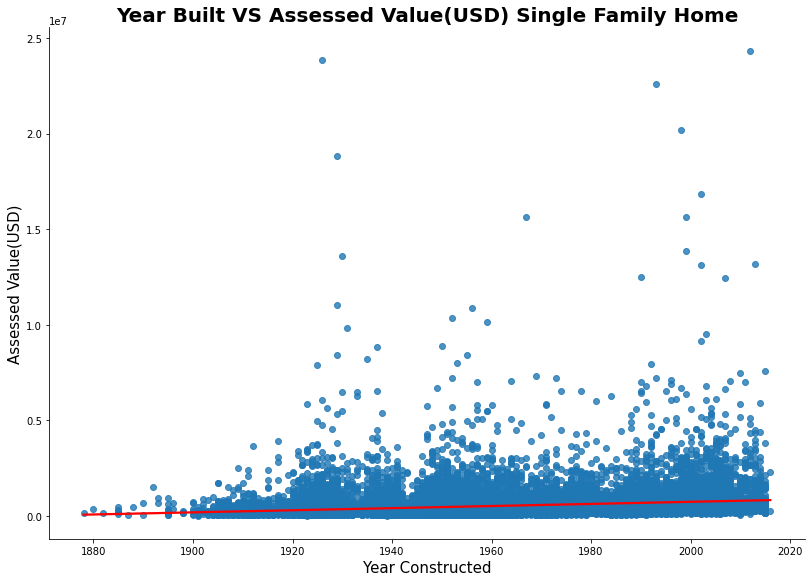

In [33]:
# Create lmplot showing regression
sns.lmplot(x="built_year", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Year Built VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Year Constructed', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

##### Calculate the 'r' and 'p' values

In [34]:
# Formulated hypothesis
H0 = 'There is no correlation between a home\'s year built and and its variation in assessed value.'
H1 = 'A home\'s age is correlated to its variation in assessed value.'

# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p_value = spearmanr(train.built_year, train.assessed_value)

print('\nSPEARMANSR YEAR BUILT')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')


SPEARMANSR YEAR BUILT

	- Correlation Coefficient: 0.2776150044515125

	- P-value: 0.0



##### Test the hypothesis

In [35]:
alpha = 0.05

if p_value > alpha:
    print(f"\nFAILED TO REJECT: {H0}\n")

else:
    print(f"\nREJECT: {H0}\n")


REJECT: There is no correlation between a home's year built and and its variation in assessed value.



## Summry: Top 3 Drivers for Assessed Value

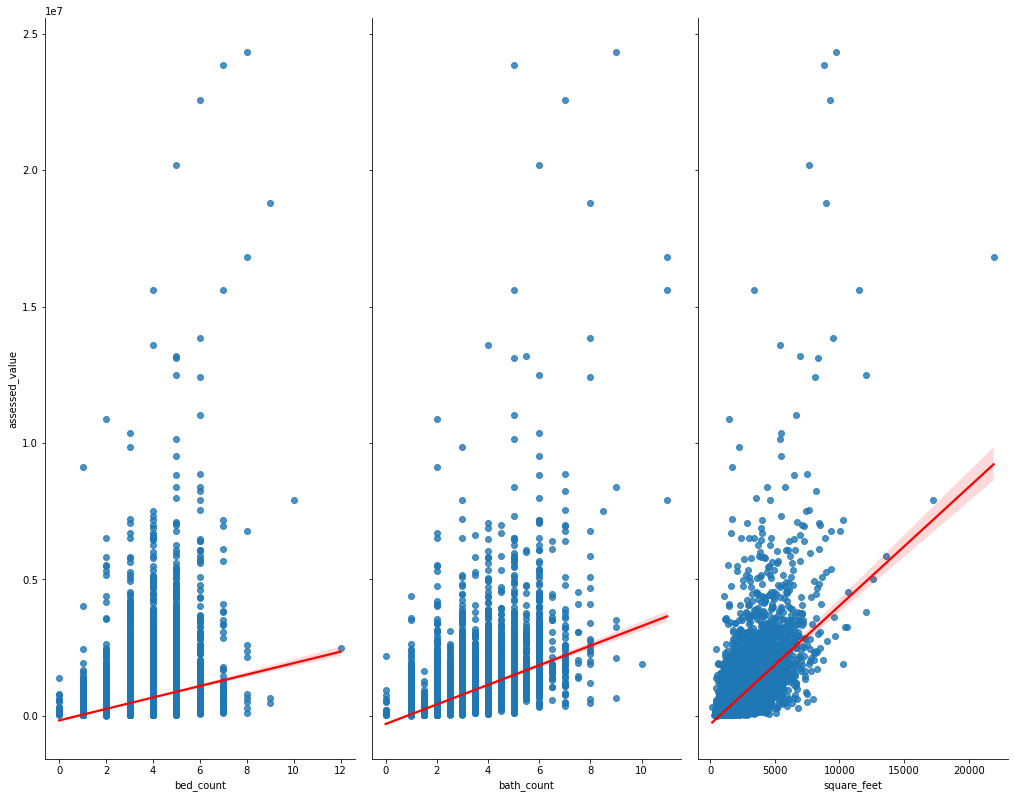

In [36]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['bed_count', 'bath_count', 'square_feet'], 
                 y_vars = ['assessed_value'])

g.fig.set_size_inches(15,15)

## Summary: Other Factors Relations to Assessed Value

>- ### Examine Built / Age relations to assessed value. Shows increased linear regression suggesting its a driver

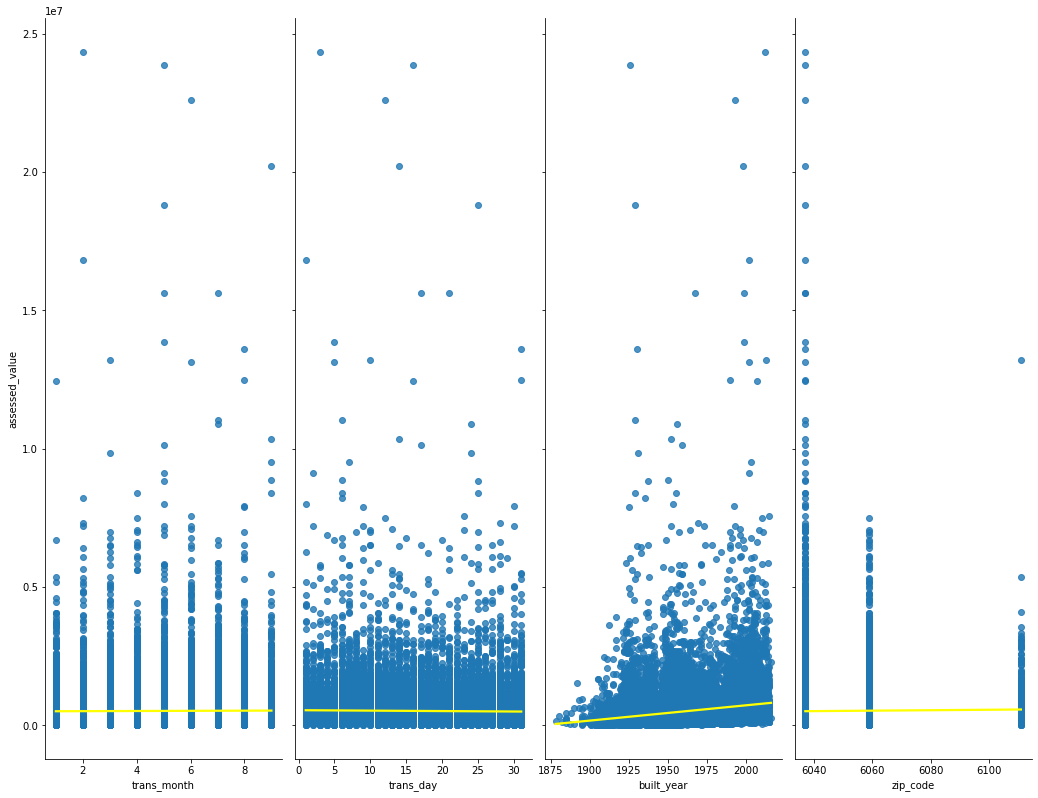

In [37]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'yellow'}}, x_vars = ['trans_month', 'trans_day', 'built_year', 'zip_code'], 
                 y_vars = ['assessed_value'])

g.fig.set_size_inches(15,15)

# <u>Correlations Calculations:</u> 

### Zillow Correlation 

In [38]:
zillow_corr = train.drop(columns = ['city','trans_day', 'zip_code','built_year']).corr()
zillow_corr

,bed_count,bath_count,square_feet,assessed_value,trans_month
bed_count,1.000000,0.646463,0.629773,0.273847,0.009464
bath_count,0.646463,1.000000,0.848716,0.507330,0.015495
square_feet,0.629773,0.848716,1.000000,0.599351,0.007299
assessed_value,0.273847,0.507330,0.599351,1.000000,0.009645
trans_month,0.009464,0.015495,0.007299,0.009645,1.000000


### Correlation Heatmap Matrix

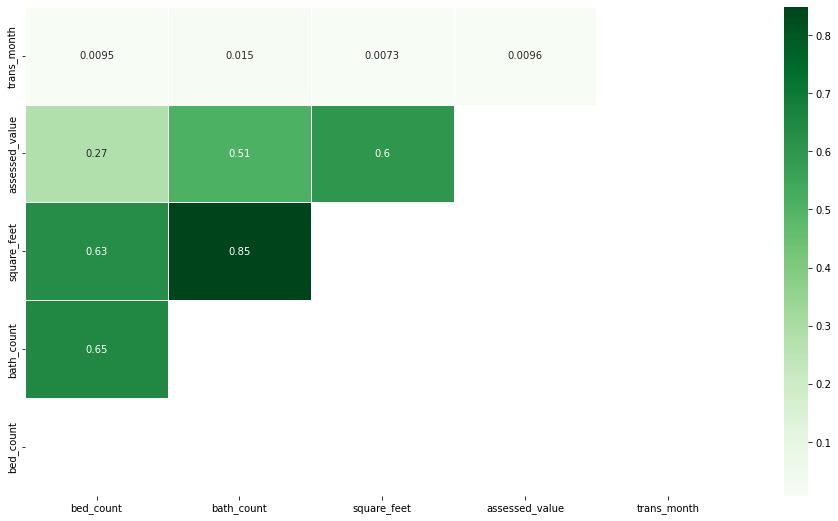

In [39]:
plt.figure(figsize=(16,9))
sns.heatmap(zillow_corr, cmap='Greens', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.ylim(0, 5)

plt.show()

### Correlation Coefficient (Pearsonr - Constant linear relationship)

In [40]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.square_feet, train.assessed_value)
print('\nPEARSONR')

print(f'\n\t- Correlation Coefficient: {r}\n\n\t- P-value: {p_value}\n')



PEARSONR

	- Correlation Coefficient: 0.5993514769224604

	- P-value: 0.0



### With Spearman (Normally Distributed Data)

In [41]:
# Spearman (Normally distributed

zillow_spearman = train.drop(columns=['city','trans_day', 'zip_code','built_year']).corr(method='spearman')
zillow_spearman


,bed_count,bath_count,square_feet,assessed_value,trans_month
bed_count,1.000000,0.639101,0.667909,0.296526,0.010176
bath_count,0.639101,1.000000,0.839867,0.489350,0.018618
square_feet,0.667909,0.839867,1.000000,0.529989,0.015074
assessed_value,0.296526,0.489350,0.529989,1.000000,0.018006
trans_month,0.010176,0.018618,0.015074,0.018006,1.000000


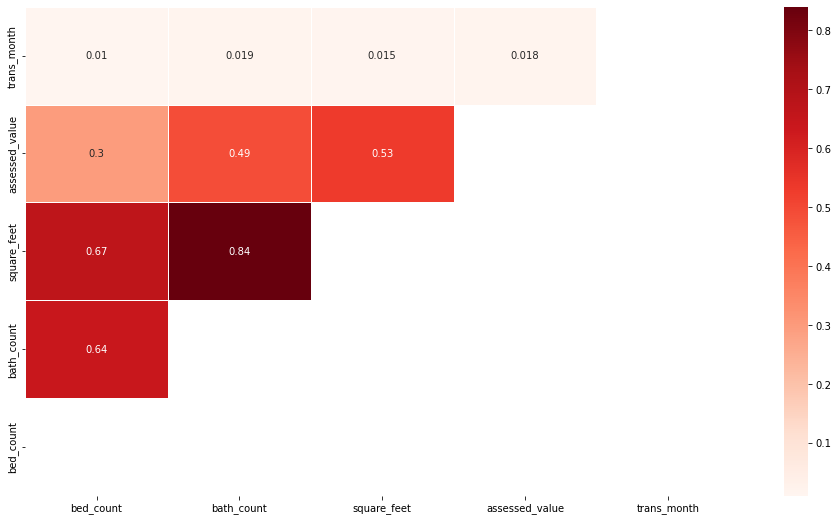

In [42]:
plt.figure(figsize=(16,9))

sns.heatmap(zillow_spearman, cmap='Reds', annot = True, linewidth=0.5, mask= np.triu(zillow_corr))

plt.ylim(0, 5)

plt.show()


# <u>Feature Engineering</u>

>#### Finding features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [43]:
# Select features to explore 

X_train = train[['bed_count', 'bath_count', 'square_feet',
                 'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet', 
                       'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet', 
               'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_test = test.assessed_value

## (1). SelectKBest

In [44]:
select_k_best = select_kbest_feature_engineering(X_train, y_train, 3)
select_k_best

Enter count of SelectKBest features to return: 3


Index(['bed_count', 'bath_count', 'square_feet'], dtype='object')

>### Rank SelectKBest Features

In [45]:
kbest = SelectKBest(f_regression, k = 2)

kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7f7d22260e50>)

In [46]:
kbest_results = pd.DataFrame(dict(p = kbest.pvalues_, 
                                  f = kbest.scores_), 
                             index = X_train.columns)
kbest_results

,p,f
bed_count,0.000000e+00,2375.005194
bath_count,0.000000e+00,10153.362041
square_feet,0.000000e+00,16422.875486
trans_month,9.875797e-02,2.725661
trans_day,6.599920e-04,11.601159
built_year,2.183660e-208,964.559699
zip_code,3.179239e-05,17.312943


In [47]:

X_train_transformed = pd.DataFrame(kbest.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[kbest.get_support()])


X_train_transformed.head()


,bath_count,square_feet
16035,2.0,1522.0
44800,1.0,900.0
20047,1.0,807.0
5077,3.0,2458.0
36597,2.0,1386.0


## (2). Recursive Feature Elimination (RFE)

In [48]:
rfe_feature_engineering(X_train, y_train, 3)

Enter count of RFE features to return: 3


Index(['bed_count', 'bath_count', 'built_year'], dtype='object')

>### Rank RFE Features

In [49]:
# Call linear reg'
model = LinearRegression()

# Fit the model and select best two features (n_features_to_select = 2)
rfe = RFE(model, n_features_to_select = 2)
rfe.fit(X_train, y_train)

# Rank the RFE features
pd.DataFrame({'rfe_ranks': rfe.ranking_}, index = X_train.columns)

,rfe_ranks
bed_count,1
bath_count,1
square_feet,5
trans_month,4
trans_day,3
built_year,2
zip_code,6


In [50]:
# RFE Ranking
X_train_transformed = pd.DataFrame(rfe.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[rfe.support_])

X_train_transformed.head()

,bed_count,bath_count
16035,3.0,2.0
44800,2.0,1.0
20047,2.0,1.0
5077,3.0,3.0
36597,3.0,2.0


# <u>Exploration Summary</u>

- The features evaluated in this datasets are:
 - Squre feet
 - Number of beds a home has
 - Number of bath counts
 - The month transaction was conducted
 - The Location of the property by zip-code

### (i). SelectKBest Feature Results:

 - ### [ 'bed_count', 'bath_count', 'square_feet' ]


### (ii). RFE Feature Results:
 - ### ['bed_count', 'bath_count', 'built_year']

### (iii). Overall Ranking
 - ### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day', 'built_year', 'zip_code']

## <u>Observations</u>

- ##### Note correlation do not tell the complete story of data. It measures linear relationship between 2 variables. This project approach is to compare two relationship individually and check effects on assessed value of homes in 2017.
- __Heat map:__ 
  - Sqaure feet -> 0.6
  - Bath count -> 0.51
  - Bed count -> 0.27
 
- __SpearmanR:__
  - Sqaure feet -> 0.53
  - Bath count -> 0.49
  - Bed count -> 0.3
  
- ##### The heatmap summary and SpearmanR summary above shows that square feet is the leading feature contributing to assessed value for 2017 Zillow properties. 
- ##### With alpha level of 0.05, all independeny features tested resulted in reject in null hypothesis. __Meaning,__ there are correlation between above features with assessed value. 




# Moving forward... 
## Since square feet is the leading driver for assessed value, we will build a model with this feature to predict assessed home value for single household family home in 2017. 


>- ## If time permits:
>- #### Year built effect on assessed value
>- #### Effects of Location
>- #### Square feet and bath count 84%


# <u>Modeling Phase: </u>



In [51]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


## Establish Baseline

In [97]:
# Create two-dimentional array with assigned column names

zillow_main_feature = pd.DataFrame(np.array(train[['square_feet', 'assessed_value']].to_numpy()), columns = ['square_feet', 'assessed_value'])
zillow_main_feature.head(3)


,square_feet,assessed_value
0,1522.0,64360.0
1,900.0,338073.0
2,807.0,51727.0


#### Create the yhat feature

In [98]:
zillow_main_feature['yhat_baseline'] = zillow_main_driver_feature['assessed_value'].mean()
zillow_main_feature.head()

,square_feet,assessed_value,yhat_baseline
0,1522.0,64360.0,525863.630781
1,900.0,338073.0,525863.630781
2,807.0,51727.0,525863.630781
3,2458.0,653996.0,525863.630781
4,1386.0,242779.0,525863.630781


In [99]:
# # Map X, and y to features of interest and check lenght

# X = zillow_main_driver_feature['square_feet']
# y = zillow_main_driver_feature['assessed_value']

In [100]:
# assessed_value_regression_plot(zillow_main_driver_feature, X, y)

## Build the Model

In [118]:
# Import the required library
from sklearn.linear_model import LinearRegression
from math import sqrt

# Create the model
model = LinearRegression()

# Fit the model 
model.fit(zillow_main_feature[['square_feet']], zillow_main_feature.assessed_value)

# compute predictions and add to original dataframe
zillow_main_feature['yhat_predicted'] = model.predict(zillow_main_feature[['square_feet']])

zillow_main_feature.head(3)

,square_feet,assessed_value,yhat_baseline,yhat_predicted
0,1522.0,64360.0,525863.630781,351675.383754
1,900.0,338073.0,525863.630781,81428.525805
2,807.0,51727.0,525863.630781,41021.841257


# Calculate Metrics (Model & Baseline) 

> ### (i). Sum of Squared Errors (SSE) 

In [131]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# SSE Model
SSE_model1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted) * len(zillow_main_feature)

# SSE Baseline 
SSE_baseline1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline) * len(zillow_main_feature)


print(f'\n\tSSE Baseline: {SSE_baseline1:,} \n\n\tSSE Model: {SSE_model1:,}\n')




	SSE Baseline: 1.5009956672453998e+16 

	SSE Model: 9,618,047,121,404,176.0



> ### (ii). Explained Sum of Squares (ESS)

In [130]:
# ESS Model 
ESS_model1 = sum(zillow_main_feature.yhat_predicted - zillow_main_feature.assessed_value.mean() ** 2)

# ESS Baseline
ESS_baseline1 = sum(zillow_main_feature.yhat_baseline - zillow_main_feature.assessed_value.mean() ** 2)

print(f'\n\tESS Baseline: {ESS_baseline1:,} \n\n\tESS Model: {ESS_model1:,}\n')



	ESS Baseline: -8,101,558,950,731,026.0 

	ESS Model: -8,101,558,950,728,798.0



> ### (iii). Total Sum of Squares (TSS)

In [132]:
# TSS Model 
TSS_model1 = (ESS_model1 + SSE_model1)

# TSS Baseline
TSS_baseline1 = (ESS_baseline1 + SSE_baseline1)

print(f'\n\tTSS Baseline: {TSS_baseline1:,} \n\n\tTSS Model: {TSS_model1:,}\n')



	TSS Baseline: 6,908,397,721,722,972.0 

	TSS Model: 1,516,488,170,675,378.0



 > ### (iv). Mean Squared Error  (MSE)

In [133]:
# MSE Model 
MSE_model1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted)

# MSE Baseline
MSE_baseline1 = mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline)

print(f'\n\tMSE Baseline: {MSE_baseline1:,} \n\n\tMSE Model: {MSE_model1:,}\n')



	MSE Baseline: 512,337,668,445.7111 

	MSE Model: 328,294,607,686.9364



> ### (v). Root Mean Squared Error (RMSE)

In [136]:
# RMSE Model
RMSE_model1 = sqrt(mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_predicted))

# RMSE Baseline
RMSE_baseline1 = sqrt(mean_squared_error(zillow_main_feature.assessed_value, zillow_main_feature.yhat_baseline))

print(f'\n\tRMSE Baseline: {RMSE_baseline1:,} \n\n\tRMSE Model: {RMSE_model1:,}\n')



	RMSE Baseline: 715,777.6669090138 

	RMSE Model: 572,969.9884696723



## Compare SSE of baseline vs model

In [135]:
(SSE_baseline1 == SSE_model1)


False

In [143]:
# Comprehensive with all the calculations

baseline = pd.DataFrame(np.array(['SSE_baseline1', 'MSE_baseline1', 'RMSE_baseline1']), columns=['BASELINE PREDICTIONC'])
modeled_prediction = pd.DataFrame(np.array(['SSE_model1', 'MSE_model1', 'RMSE_model1']), columns=['MODEL PREDICTIONS'])

baseline['Baseline_Error'] = np.array([SSE_baseline1, MSE_baseline1, RMSE_baseline1])
modeled_prediction['Model_Error'] = np.array([SSE_model1, MSE_model1, RMSE_model1])


print(f'{baseline}\n\n {modeled_prediction}')

  BASELINE PREDICTIONC  Baseline_Error
0        SSE_baseline1    1.500996e+16
1        MSE_baseline1    5.123377e+11
2       RMSE_baseline1    7.157777e+05

   MODEL PREDICTIONS   Model_Error
0        SSE_model1  9.618047e+15
1        MSE_model1  3.282946e+11
2       RMSE_model1  5.729700e+05


## Variance as Inferred from Model (Model Error - Baseline Error)

In [144]:
baseline['Error_Difference'] = (modeled_prediction.Model_Error - baseline.Baseline_Error)

baseline

,BASELINE PREDICTIONC,Baseline_Error,Error_Difference
0,SSE_baseline1,1.500996e+16,-5.391910e+15
1,MSE_baseline1,5.123377e+11,-1.840431e+11
2,RMSE_baseline1,7.157777e+05,-1.428077e+05


## Model Evaluations

### Is my model better than my baseline predictions?

## Model Selection & Testing

# Conclusions and Delivery: 